In [2]:
import cv2
import dlib
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

import keras
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, Input, MaxPool2D, Reshape
from keras.models import Model, Sequential
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [3]:
df = pd.read_csv("fer2013.csv")
emotion_labels = {0: "Angry", 1: "Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise", 6:"Neutral"}
labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

In [4]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
df["Usage"].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [6]:
def process_data(main_df, use):
    subset_df = main_df[main_df["Usage"] == use]
    subset_df.drop(columns=['Usage'], inplace=True)
    subset_df['pixels'] = subset_df['pixels'].apply(lambda pixel_str: np.fromstring(pixel_str, sep=' '))
    x = np.vstack(subset_df['pixels'].values)
    x = x.reshape(-1, 48, 48, 1)
    y = subset_df['emotion'].values
    y = np_utils.to_categorical(y)
    
    return x, y

In [31]:
def extract_landmark_features(images_array, flatten=False):
    face_landmarks_res = []
    # load detector and predictors from dlib
    predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
    
    # since our images are already cropped to contain only the face, we don't need to use a detector 
    rect = [dlib.rectangle(left=1, top=1, right=47, bottom=47)]
        
    # detect face using openCV i.e cv2
    for img in images_array:
        cv2.imwrite('temp.jpg', img)
        saved_img = cv2.imread('temp.jpg', 0)
        face_landmarks = predictor( saved_img, rect[0])
        face_landmarks_pixels = np.array([[point.x, point.y] for point in face_landmarks.parts()])
        # print(face_landmarks)
        face_landmarks_res.append(face_landmarks_pixels)
    if flatten:
        face_landmarks_res = [res.flatten() for res in face_landmarks_res]
    print(face_landmarks_res.shape. face_landmarks_res[0].shape)
    return np.asarray(face_landmarks_res)

In [8]:
# process the training, validation and test data
x_train, y_train = process_data(df, 'Training')
x_validation, y_validation = process_data(df, 'PublicTest')
x_test, y_test = process_data(df, "PrivateTest")

/Users/ritvikareddy 1/Documents/GitHub/ml-project/venv/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Users/ritvikareddy 1/Documents/GitHub/ml-project/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [32]:
# get face landmarks
x_train_landmarks = extract_landmark_features(x_train)
x_validation_landmarks = extract_landmark_features(x_validation)
x_test_landmarks = extract_landmark_features(x_test)

AttributeError: 'list' object has no attribute 'shape'

In [10]:
x_train.shape, x_train_landmarks.shape

((28709, 48, 48, 1), (28709, 68, 2))

In [44]:
# cnn for just the raw pixels
images_nn = Input(shape=(48,48,1))
images_conv1 = Conv2D(64, 3, kernel_initializer='he_normal', activation='relu')(images_nn)
images_batchnorm1 = BatchNormalization()(images_conv1)

images_conv2 = Conv2D(64, 3, activation='relu')(images_batchnorm1)
images_batchnorm2 = BatchNormalization()(images_conv2)
images_pool1 = MaxPool2D(pool_size=(2,2), strides=2)(images_batchnorm2)
images_dropout1 = Dropout(0.6)(images_pool1)

images_conv3 = Conv2D(32, 3, activation='relu')(images_dropout1)
images_batchnorm3 = BatchNormalization()(images_conv3)

images_conv4 = Conv2D(32, 3, activation='relu')(images_batchnorm3)
images_batchnorm4 = BatchNormalization()(images_conv4)

images_conv5 = Conv2D(32, 3, activation='relu')(images_batchnorm4)
images_batchnorm5 = BatchNormalization()(images_conv5)
images_pool2 = MaxPool2D(pool_size=(2,2), strides=2)(images_batchnorm5)
images_dropout2 = Dropout(0.6)(images_pool2)

images_flat1 = Flatten()(images_dropout2)
images_dense1 = Dense(128, activation='relu')(images_flat1)
images_batchnorm6 = BatchNormalization()(images_dense1)
images_dropout3 = Dropout(0.6)(images_batchnorm6)

# cnn for landmark features
# input shape will be 68*2 (from landamrks)
landmarks_features_nn = Input(shape=(68,2))
landmarks_features_flat1 = Flatten()(landmarks_features_nn)
landmarks_features_dense1 = Dense(1024, activation='relu')(landmarks_features_flat1)
landmarks_features_batchnorm1 = BatchNormalization()(landmarks_features_dense1)

landmarks_features_dense2 = Dense(128, activation='relu') (landmarks_features_batchnorm1)
landmarks_features_batchnorm2 = BatchNormalization()(landmarks_features_dense2)

# merge final outputs from both networks
merged_net = keras.layers.merge.concatenate([images_dropout3, landmarks_features_batchnorm2],
                                           axis=-1)

output_layer = Dense(7, activation='softmax')(merged_net)

model = Model(inputs=[images_nn, landmarks_features_nn], outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 46, 46, 64)   640         input_19[0][0]                   
__________________________________________________________________________________________________
batch_normalization_73 (BatchNo (None, 46, 46, 64)   256         conv2d_46[0][0]                  
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 44, 44, 64)   36928       batch_normalization_73[0][0]     
__________________________________________________________________________________________________
batch_norm

In [46]:
# save best weights
checkpoint = ModelCheckpoint(filepath='cnn_landmarks_4', verbose=1, save_best_only=True)

# num epochs
epochs = 12

# run model
model_history = model.fit(
    [x_train, x_train_landmarks], y_train, epochs=epochs, shuffle=True, batch_size=100,
    validation_data=([x_validation, x_validation_landmarks], y_validation),
    callbacks=[checkpoint], verbose=2)

# save model to json
model_json = model.to_json()
with open("cnn_landmarks4.json", "w") as json_file:
    json_file.write(model_json)

Train on 28709 samples, validate on 3589 samples
Epoch 1/12
 - 698s - loss: 1.7855 - acc: 0.3893 - val_loss: 3.4043 - val_acc: 0.3176

Epoch 00001: val_loss improved from inf to 3.40427, saving model to cnn_landmarks_4
Epoch 2/12
 - 709s - loss: 1.4601 - acc: 0.4528 - val_loss: 1.7864 - val_acc: 0.3357

Epoch 00002: val_loss improved from 3.40427 to 1.78641, saving model to cnn_landmarks_4
Epoch 3/12
 - 919s - loss: 1.3901 - acc: 0.4719 - val_loss: 1.8723 - val_acc: 0.3435

Epoch 00003: val_loss did not improve from 1.78641
Epoch 4/12
 - 1092s - loss: 1.3522 - acc: 0.4869 - val_loss: 2.0781 - val_acc: 0.3550

Epoch 00004: val_loss did not improve from 1.78641
Epoch 5/12
 - 1187s - loss: 1.3276 - acc: 0.4921 - val_loss: 6.2310 - val_acc: 0.1402

Epoch 00005: val_loss did not improve from 1.78641
Epoch 6/12
 - 926s - loss: 1.3158 - acc: 0.4960 - val_loss: 2.7862 - val_acc: 0.1739

Epoch 00006: val_loss did not improve from 1.78641
Epoch 7/12
 - 919s - loss: 1.3007 - acc: 0.5055 - val_los

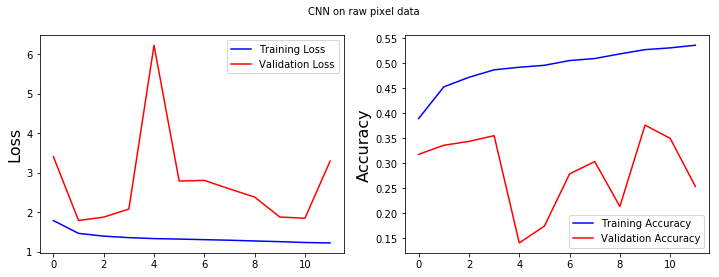

In [47]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.suptitle('CNN on raw pixel data', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(model_history.history['loss'], color='b', label='Training Loss')
plt.plot(model_history.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(model_history.history['acc'], color='b', label='Training Accuracy')
plt.plot(model_history.history['val_acc'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [49]:
y_predicted_probs = model.predict([x_test, x_test_landmarks], verbose=1)

3589/3589 [==============================] - 30s 8ms/step


In [50]:
score = model.evaluate([x_test, x_test_landmarks], y_test, verbose=1)

3589/3589 [==============================] - 22s 6ms/step


In [51]:
print("Metrics: ", model.metrics_names)
print("Loss on test data", score[0])
print("Test Accuracy", score[1])

Metrics:  ['loss', 'acc']
Loss on test data 3.3261061906482423
Test Accuracy 0.2429646140986347


In [ ]:
def convert_probs_to_labels(y_probs, labels):
    predicted_label = lambda x: labels[x.argmax()]
    return [predicted_label(each) for each in y_probs]

In [ ]:
y_predicted_labels = convert_probs_to_labels(y_predicted_probs, labels)
y_actual_labels = convert_probs_to_labels(y_test, labels)

In [ ]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
cnf_matrix = confusion_matrix(y_actual_labels, y_predicted_labels)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=labels,
                      title='Confusion Matrix for Test Data with Raw Pixels and HoG features')
plt.show()
fig.savefig('confusion_matrix_hog.png')

In [ ]:
def test_for_single_image(file_name, model, labels):
    image_pixels = cv2.imread(file_name, 0)
#     print(len(image_pixels))
    image_input = image_pixels.reshape(-1, 48, 48, 1)
    predicted_emotion = model.predict(image_input, verbose=0)
#     print(predicted_emotion)
    print("This image is classified to be {} with {:.2f}% confidence".format(
        labels[predicted_emotion.argmax()],predicted_emotion.max()*100))
    

In [ ]:
test_for_single_image('100th.jpg', model, labels)

In [ ]:
test_for_single_image('ashok.jpg', model, labels)

In [ ]:
test_for_single_image('ashok2.png', model, labels)

In [ ]:
test_for_single_image('rose2.jpg', model, labels)

In [ ]:
test_for_single_image('rose3.jpg', model, labels)

In [ ]:
test_for_single_image('jose.png', model, labels)

In [ ]:
test_for_single_image('rohit_happy.jpeg', model, labels)

In [ ]:
test_for_single_image('ankita.png', model, labels)